# Predictive Modeling
### Using Naive Bayes, Decision Tree, Random Forest, and SVM
- **The first step is to import necessary libraries.**

In [2]:
# custom functions for this project
from functions import *

# dataframe libraries
import pandas as pd
import numpy as np

# graphing libraries
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style('ticks')
from wordcloud import WordCloud

# text processing
import nltk
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer 
from textblob import TextBlob as tb
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import matutils, models
import scipy.sparse
import pronouncing

# modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.svm import SVC

from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

# miscellany
import re
import string
from collections import Counter
import time
import gzip
import pickle

# reload functions/libraries when edited
%load_ext autoreload
%autoreload 2

# ignore tensorflow warnings (code from: https://stackoverflow.com/questions/32612180/eliminating-warnings-from-scikit-learn)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

# increase column width of dataframe
pd.set_option('max_colwidth', 150)

Using TensorFlow backend.
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/learn-env/lib/p

### Load DataFrame

In [3]:
# uncomment to load
with gzip.open('data/poetry_all_genres_df_edit.pkl', 'rb') as hello:
    df = pickle.load(hello)

In [4]:
df.columns

Index(['poet_url', 'genre', 'poem_url', 'poet', 'title', 'poem_lines',
       'poem_string', 'clean_lines', 'num_lines', 'num_words', 'avg_len_line',
       'sentiment_polarity_score', 'sentiment_polarity',
       'sentiment_subjectivity_score', 'num_end_rhymes', 'end_rhyme_ratio',
       'end_rhyme', 'num_syllables', 'avg_syllables_word', 'lines_titled',
       'string_titled', 'string_cleaned'],
      dtype='object')

In [5]:
# check out the class balance
df.genre.value_counts(normalize=True)

modern                            0.276481
victorian                         0.138997
romantic                          0.086035
imagist                           0.076956
new_york_school                   0.057069
black_mountain                    0.055556
new_york_school_2nd_generation    0.041505
language_poetry                   0.041505
confessional                      0.038046
black_arts_movement               0.035668
georgian                          0.034587
objectivist                       0.034371
harlem_renaissance                0.031993
beat                              0.031777
fugitive                          0.019455
Name: genre, dtype: float64

- **Classes are fairly balanced.**

### Create features and target dataframes

In [6]:
# assign a features dataframe
X = df[['num_lines', 'avg_len_line', 'sentiment_polarity_score', 'sentiment_subjectivity_score', 'num_end_rhymes', 
        'avg_syllables_word', 'string_titled', 'string_cleaned']]
# assign a target variable
y = df['genre']

### Train-Test Split

In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3469, 8) (3469,)
(1157, 8) (1157,)


## Baseline model -- tf-idf vectors only

In [8]:
# instantiate the vectorizer
vectorizer = TfidfVectorizer()

# fit to training data's string_cleaned column and transform train and test sets
X_train_vec_matrix = vectorizer.fit_transform(X_train.string_cleaned)
X_test_vec_matrix = vectorizer.transform(X_test.string_cleaned)

In [9]:
# turn our tf-idf vectors into a dataframe so we can better view feature importances
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec_matrix, columns=vectorizer.get_feature_names())
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec_matrix, columns=vectorizer.get_feature_names())

In [10]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_vec = BernoulliNB()

# fit it to our training set
bnb_baseline_vec.fit(X_train_vec, y_train)

CPU times: user 4.2 s, sys: 520 ms, total: 4.72 s
Wall time: 4.24 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [11]:
%%time

# predict the new document from the testing dataset
y_train_preds_vec = bnb_baseline_vec.predict(X_train_vec)
y_test_preds_vec = bnb_baseline_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
bnb_baseline_vec_acc_train = accuracy_score(y_train, y_train_preds_vec)
bnb_baseline_vec_f1_train = f1_score(y_train, y_train_preds_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_vec_acc_train}')
print(f'F1 score: {bnb_baseline_vec_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_vec_acc_test = accuracy_score(y_test, y_test_preds_vec)
bnb_baseline_vec_f1_test = f1_score(y_test, y_test_preds_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_vec_acc_test}')
print(f'F1 score: {bnb_baseline_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_vec))

-----TRAIN-----
Accuracy: 0.3753243009512828
F1 score: 0.2933900591813645

-----TEST-----
Accuracy: 0.3258426966292135
F1 score: 0.20737231022973

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.25      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.00      0.00      0.00        64
                  confessional       0.00      0.00      0.00        44
                      fugitive       0.00      0.00      0.00        22
                      georgian       0.00      0.00      0.00        40
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        modern

- **Not too bad for a baseline. Certainly better than just predicting 'modern', which would give you a 29% accuracy.**
- **That said, it is indeed overpredicting on 'modern'.**

### Feature importances

- **Code modified from: https://stackoverflow.com/questions/50526898/how-to-get-feature-importance-in-naive-bayes**

In [12]:
# assign the top 10 feature importances for each class
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [13]:
# match them up with the proper label
print(np.take(X_train_vec.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_vec.columns, pre1900_class_prob_sorted[:10]))

Index(['aaaall', 'aaron', 'aalto', 'aaa'], dtype='object')
Index(['aaa', 'migratorious', 'milan', 'milder', 'mildness', 'miletus',
       'milholland', 'militarisme', 'milked', 'milkmaid'],
      dtype='object')
Index(['zwim', 'hoper', 'hopped', 'shipwright', 'hopscotch', 'horace',
       'horatian', 'shipwreck', 'horeb', 'shipwrack'],
      dtype='object')
Index(['aaa', 'grievings', 'rouchled', 'rotunda', 'rottenness', 'grig',
       'rotor', 'grille', 'roto', 'grimace'],
      dtype='object')


## Baseline model -- vectors + numerical data

- **Create dataframe.**

In [12]:
# separate out our numerical data
X_train_nums = X_train.drop(columns=['string_titled', 'string_cleaned'])
X_test_nums = X_test.drop(columns=['string_titled', 'string_cleaned'])

- **Scale and combine.**

In [13]:
# instantiate our scaler
scaler = MinMaxScaler()

# scale our numerical data
X_train_scaled = scaler.fit_transform(X_train_nums)
X_test_scaled = scaler.transform(X_test_nums)

# turn the arrays into dataframes
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_nums.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_nums.columns)

In [14]:
# combine the numerical and vector dataframes for both train and test sets
X_train_combo = pd.concat([X_train_scaled_df, X_train_vec], axis=1)
X_test_combo = pd.concat([X_test_scaled_df, X_test_vec], axis=1)

- **Model.**

In [15]:
%%time

# instantiate the naive bayes classifier
bnb_baseline_combo = BernoulliNB()

# fit it to our training set
bnb_baseline_combo.fit(X_train_combo, y_train)

CPU times: user 8.53 s, sys: 1.39 s, total: 9.93 s
Wall time: 9.5 s


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [16]:
%%time

# predict the new document from the testing dataset
y_train_preds_combo = bnb_baseline_combo.predict(X_train_combo)
y_test_preds_combo = bnb_baseline_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
bnb_baseline_combo_acc_train = accuracy_score(y_train, y_train_preds_combo)
bnb_baseline_combo_f1_train = f1_score(y_train, y_train_preds_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {bnb_baseline_combo_acc_train}')
print(f'F1 score: {bnb_baseline_combo_f1_train}')

# print out accuracy and f1 scores for test set
bnb_baseline_combo_acc_test = accuracy_score(y_test, y_test_preds_combo)
bnb_baseline_combo_f1_test = f1_score(y_test, y_test_preds_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {bnb_baseline_combo_acc_test}')
print(f'F1 score: {bnb_baseline_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report
print(classification_report(y_test, y_test_preds_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_combo))

-----TRAIN-----
Accuracy: 0.37590083597578555
F1 score: 0.2944305923410916

-----TEST-----
Accuracy: 0.3258426966292135
F1 score: 0.20744376406020817

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.25      0.03      0.05        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       0.00      0.00      0.00        64
                  confessional       0.00      0.00      0.00        44
                      fugitive       0.00      0.00      0.00        22
                      georgian       0.00      0.00      0.00        40
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.00      0.00      0.00        89
               language_poetry       0.00      0.00      0.00        48
                        mo

- **Practically the same result.**

### Feature importances

In [79]:
# assign the top 10 feature importances for each class
metro_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[:, 0].argsort()
modern_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[1, :].argsort()
avant_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[2, :].argsort()
pre1900_class_prob_sorted = bnb_baseline_vec.feature_log_prob_[3, :].argsort()

In [80]:
# match them up with the proper label
print(np.take(X_train_combo.columns, metro_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, modern_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, avant_class_prob_sorted[:10]))
print(np.take(X_train_combo.columns, pre1900_class_prob_sorted[:10]))

Index(['avg_len_line', 'sentiment_subjectivity_score',
       'sentiment_polarity_score', 'num_lines'],
      dtype='object')
Index(['num_lines', 'mightier', 'migliore', 'migrant', 'mike', 'mildew',
       'mildly', 'mile', 'milieu', 'militant'],
      dtype='object')
Index(['zunbrowned', 'hop', 'hope', 'shipboard', 'hopefully', 'hopeless',
       'hopelessly', 'ship', 'hopped', 'shiny'],
      dtype='object')
Index(['num_lines', 'griddlecake', 'rotha', 'rote', 'rotator', 'grieve',
       'rotate', 'grievings', 'rot', 'griffin'],
      dtype='object')


- **Some engineered features made it into this one.**

## Decision Tree -- tf-idf vectors only

- **I'll first take a quick look at cross validation scores.**

In [29]:
# instantiate the naive bayes classifier
tree_vec = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.23342939, 0.24495677, 0.21037464, 0.19884726, 0.24495677,
       0.22478386, 0.23342939, 0.19884726, 0.21037464, 0.26011561])

- **Naive Bayes performs better.**

## Decision Tree -- vectors and numerical data

- **Look at cross validation scores.**

In [30]:
# instantiate the decision classifier
tree_combo = DecisionTreeClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(tree_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.26512968, 0.25360231, 0.29682997, 0.25072046, 0.3054755 ,
       0.29971182, 0.25936599, 0.24783862, 0.25936599, 0.23410405])

- **A notable improvement, so I'll fit a model.**

In [31]:
%%time

# instantiate the model
tree_combo = DecisionTreeClassifier(class_weight='balanced', random_state=1)

# fit to the training set
tree_combo.fit(X_train_combo, y_train)

CPU times: user 9.42 s, sys: 1.08 s, total: 10.5 s
Wall time: 10.5 s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight='balanced', criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

In [32]:
%%time

# predict class for the train and test sets
y_train_preds_tree_combo = tree_combo.predict(X_train_combo)
y_test_preds_tree_combo = tree_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
tree_combo_acc_train = accuracy_score(y_train, y_train_preds_tree_combo)
tree_combo_f1_train = f1_score(y_train, y_train_preds_tree_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {tree_combo_acc_train}')
print(f'F1 score: {tree_combo_f1_train}')

# print out accuracy and f1 scores for test set
tree_combo_acc_test = accuracy_score(y_test, y_test_preds_tree_combo)
tree_combo_f1_test = f1_score(y_test, y_test_preds_tree_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {tree_combo_acc_test}')
print(f'F1 score: {tree_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_tree_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_tree_combo))

-----TRAIN-----
Accuracy: 0.9991351974632459
F1 score: 0.9991372788388704

-----TEST-----
Accuracy: 0.25929127052722556
F1 score: 0.2592755522516501

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.17      0.11      0.13        37
           black_arts_movement       0.07      0.07      0.07        41
                black_mountain       0.20      0.19      0.20        64
                  confessional       0.09      0.09      0.09        44
                      fugitive       0.06      0.05      0.05        22
                      georgian       0.07      0.07      0.07        40
            harlem_renaissance       0.03      0.03      0.03        37
                       imagist       0.20      0.20      0.20        89
               language_poetry       0.16      0.19      0.17        48
                        mod

- **This is definitely better than our Naive Bayes model.**
    - **It predicts 'modern' a lot less.**
    - **Predictions seem fairly evenly spread.**
    - **Has trouble predicting avant-garde.**
    
### Feature importances

In [33]:
# create a dictionary
tree_features = dict(zip(X_train_combo.columns, tree_combo.feature_importances_))

# sort dictionary
tree_features = dict(sorted(tree_features.items(), key=lambda x: x[1], reverse=True)[:10])
tree_features

{'avg_len_line': 0.05442076809173213,
 'avg_syllables_word': 0.04292768852331993,
 'num_end_rhymes': 0.04251673090204246,
 'sentiment_polarity_score': 0.03657898969237588,
 'num_lines': 0.03514853274833197,
 'sentiment_subjectivity_score': 0.02315929514486471,
 'say': 0.012140134688109058,
 'night': 0.007525573151870927,
 'know': 0.006920030896609998,
 'field': 0.006859305412812895}

- **Mostly engineered features on top.**

## Random Forest -- tf-idf vectors only

- **First, I'll take a quick look at cross validation scores.**

In [34]:
# instantiate the naive bayes classifier
forest_vec = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_vec, X_train_vec, y_train, cv=10, n_jobs=-1)

array([0.35446686, 0.36599424, 0.36599424, 0.36023055, 0.37175793,
       0.3573487 , 0.3573487 , 0.31988473, 0.32276657, 0.35260116])

- **Compare that to vectors plus numerical data.**

## Random Forest -- vectors and numerical data

- **Take a quick look at cross validation scores.**

In [35]:
# instantiate the decision classifier
forest_combo = RandomForestClassifier(class_weight='balanced')

# fit it to our training set and evaluate
cross_val_score(forest_combo, X_train_combo, y_train, cv=10, n_jobs=-1)

array([0.36599424, 0.34293948, 0.40345821, 0.36023055, 0.38040346,
       0.37752161, 0.37175793, 0.34870317, 0.33429395, 0.3699422 ])

- **Including engineered features seems more promising, so I'll move ahead with this one.**

In [36]:
%%time

# instantiate the model
forest_combo = RandomForestClassifier(class_weight='balanced', random_state=1)

# fit to the training set
forest_combo.fit(X_train_combo, y_train)

CPU times: user 24.2 s, sys: 1.11 s, total: 25.3 s
Wall time: 25.3 s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [37]:
%%time

# predict class for the train and test sets
y_train_preds_forest_combo = forest_combo.predict(X_train_combo)
y_test_preds_forest_combo = forest_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
forest_combo_acc_train = accuracy_score(y_train, y_train_preds_forest_combo)
forest_combo_f1_train = f1_score(y_train, y_train_preds_forest_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {forest_combo_acc_train}')
print(f'F1 score: {forest_combo_f1_train}')

# print out accuracy and f1 scores for test set
forest_combo_acc_test = accuracy_score(y_test, y_test_preds_forest_combo)
forest_combo_f1_test = f1_score(y_test, y_test_preds_forest_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {forest_combo_acc_test}')
print(f'F1 score: {forest_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_forest_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_forest_combo))

-----TRAIN-----
Accuracy: 0.9991351974632459
F1 score: 0.9991372788388704

-----TEST-----
Accuracy: 0.3647363872082973
F1 score: 0.2726841736109352

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       1.00      0.05      0.10        37
           black_arts_movement       0.00      0.00      0.00        41
                black_mountain       1.00      0.08      0.14        64
                  confessional       1.00      0.05      0.09        44
                      fugitive       0.00      0.00      0.00        22
                      georgian       0.00      0.00      0.00        40
            harlem_renaissance       0.00      0.00      0.00        37
                       imagist       0.93      0.15      0.25        89
               language_poetry       0.00      0.00      0.00        48
                        mode

- **Good results! So I'll look at a confusion matrix visualization.**

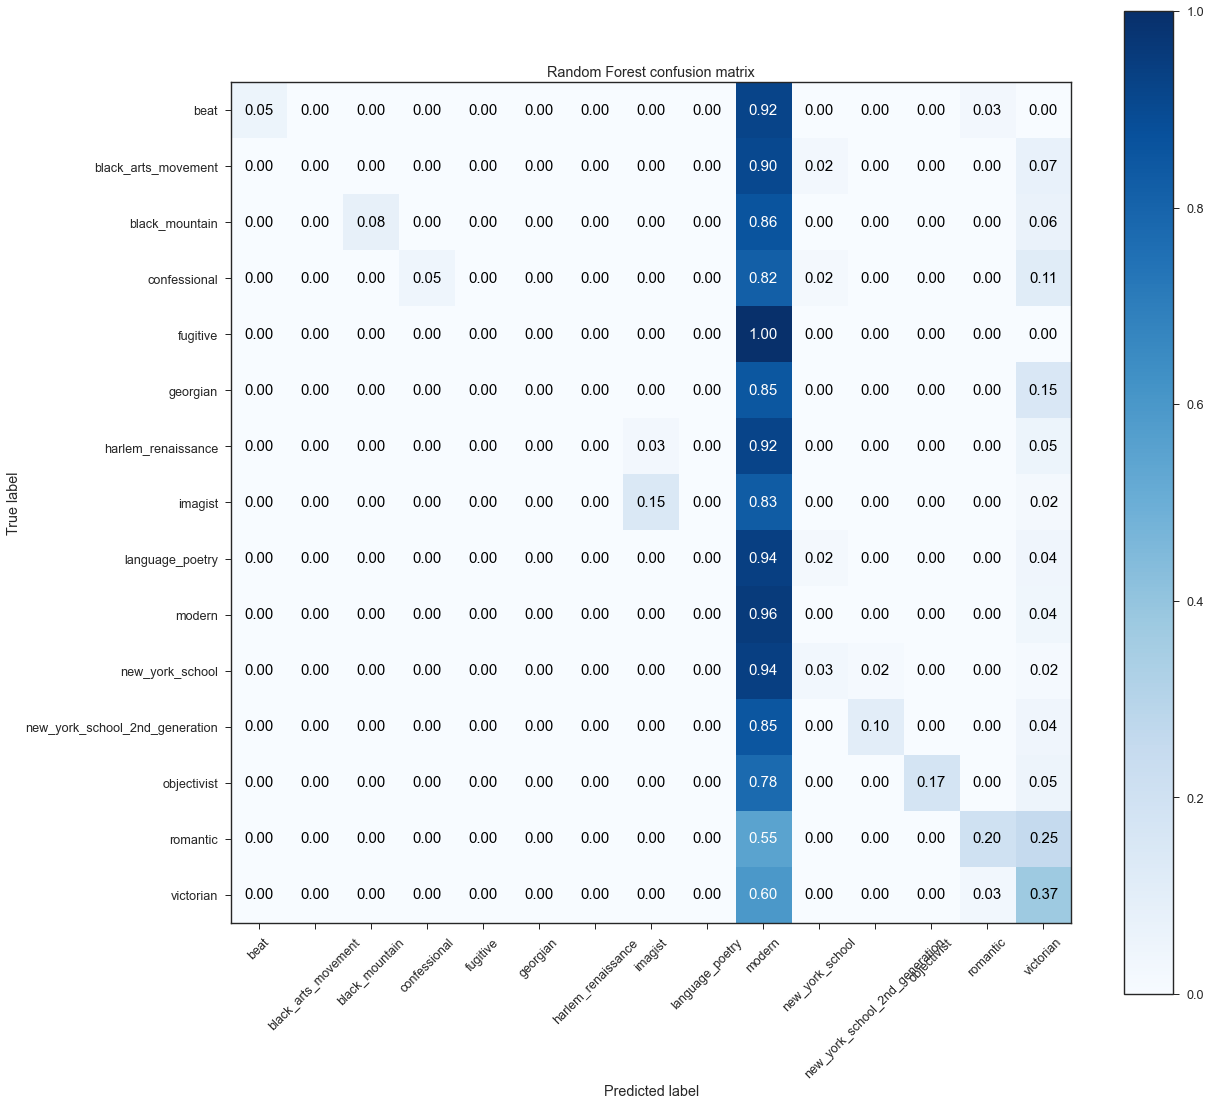

In [38]:
cm = confusion_matrix(y_test, y_test_preds_forest_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Random Forest confusion matrix',
                          cmap=plt.cm.Blues);

- **Big strides made on all categories here.**
- **Looks like some improvement could be made for avant-garde and metropolitan.**

### Feature importances

In [39]:
# create a dictionary
forest_features = dict(zip(X_train_combo.columns, forest_combo.feature_importances_))

# sort dictionary
forest_features = dict(sorted(forest_features.items(), key=lambda x: x[1], reverse=True)[:10])
forest_features

{'num_end_rhymes': 0.010022809837724538,
 'avg_len_line': 0.009890564637057848,
 'avg_syllables_word': 0.008680814935701314,
 'sentiment_polarity_score': 0.006350326480325506,
 'num_lines': 0.006328511063286595,
 'sentiment_subjectivity_score': 0.005487260394887869,
 'one': 0.0027463385520528367,
 'come': 0.0024657061522984393,
 'day': 0.0024354403697701616,
 'black': 0.002400544997359042}

- **Lots of engineered features here, and some surprise words.**
- **'Heart' appeared to be mostly within pre-1900 poetry, so that probably explains it's importance.**

## SVM Model - tf-idf vectors only

In [53]:
%%time

# instantiate the model
svm_vec = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_vec.fit(X_train_vec, y_train)

CPU times: user 16min 35s, sys: 1.76 s, total: 16min 37s
Wall time: 16min 40s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
%%time

# predict class for the train and test sets
y_train_preds_svm_vec = svm_vec.predict(X_train_vec)
y_test_preds_svm_vec = svm_vec.predict(X_test_vec)

# print out accuracy and f1 scores for train set
svm_vec_acc_train = accuracy_score(y_train, y_train_preds_svm_vec)
svm_vec_f1_train = f1_score(y_train, y_train_preds_svm_vec, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_vec_acc_train}')
print(f'F1 score: {svm_vec_f1_train}')

# print out accuracy and f1 scores for test set
svm_vec_acc_test = accuracy_score(y_test, y_test_preds_svm_vec)
svm_vec_f1_test = f1_score(y_test, y_test_preds_svm_vec, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_vec_acc_test}')
print(f'F1 score: {svm_vec_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_vec, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_vec))

-----TRAIN-----
Accuracy: 0.952435860478524
F1 score: 0.9519225125856465

-----TEST-----
Accuracy: 0.5073465859982714
F1 score: 0.4913230841326633

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.48      0.35      0.41        37
           black_arts_movement       0.43      0.24      0.31        41
                black_mountain       0.47      0.42      0.45        64
                  confessional       0.44      0.18      0.26        44
                      fugitive       0.75      0.14      0.23        22
                      georgian       0.56      0.25      0.34        40
            harlem_renaissance       0.75      0.41      0.53        37
                       imagist       0.55      0.53      0.54        89
               language_poetry       0.48      0.27      0.35        48
                        moder

### Feature importances
- **Code credit: 'https://stackoverflow.com/questions/41592661/determining-the-most-contributing-features-for-svm-classifier-in-sklearn'**

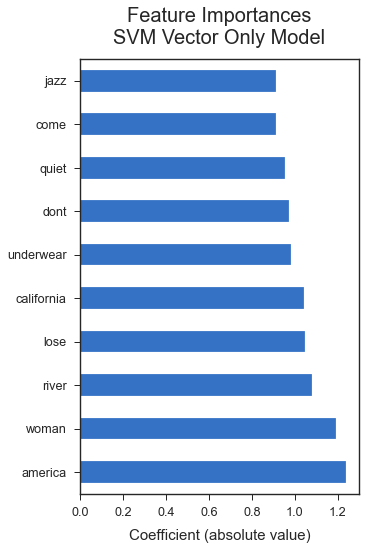

In [55]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Vector Only Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_vec.coef_[0]), index=X_train_vec.columns).nlargest(10).plot(kind='barh');

- **Quite a bump! very overfit, but I'll see if it works any better with our combo dataframes.**

## SVM - vectors + numerical data

In [56]:
%%time

# instantiate the model
svm_combo = SVC(kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo.fit(X_train_combo, y_train)

CPU times: user 14min 8s, sys: 2.59 s, total: 14min 11s
Wall time: 14min 11s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo = svm_combo.predict(X_train_combo)
y_test_preds_svm_combo = svm_combo.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train = accuracy_score(y_train, y_train_preds_svm_combo)
svm_combo_f1_train = f1_score(y_train, y_train_preds_svm_combo, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train}')
print(f'F1 score: {svm_combo_f1_train}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test = accuracy_score(y_test, y_test_preds_svm_combo)
svm_combo_f1_test = f1_score(y_test, y_test_preds_svm_combo, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test}')
print(f'F1 score: {svm_combo_f1_test}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo))

-----TRAIN-----
Accuracy: 0.919573364081868
F1 score: 0.9180773176024578

-----TEST-----
Accuracy: 0.4891961970613656
F1 score: 0.48354128252125195

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.46      0.32      0.38        37
           black_arts_movement       0.38      0.29      0.33        41
                black_mountain       0.44      0.58      0.50        64
                  confessional       0.29      0.18      0.22        44
                      fugitive       0.60      0.14      0.22        22
                      georgian       0.41      0.28      0.33        40
            harlem_renaissance       0.83      0.41      0.55        37
                       imagist       0.43      0.56      0.49        89
               language_poetry       0.33      0.31      0.32        48
                        mode

### Confusion matrix visualization

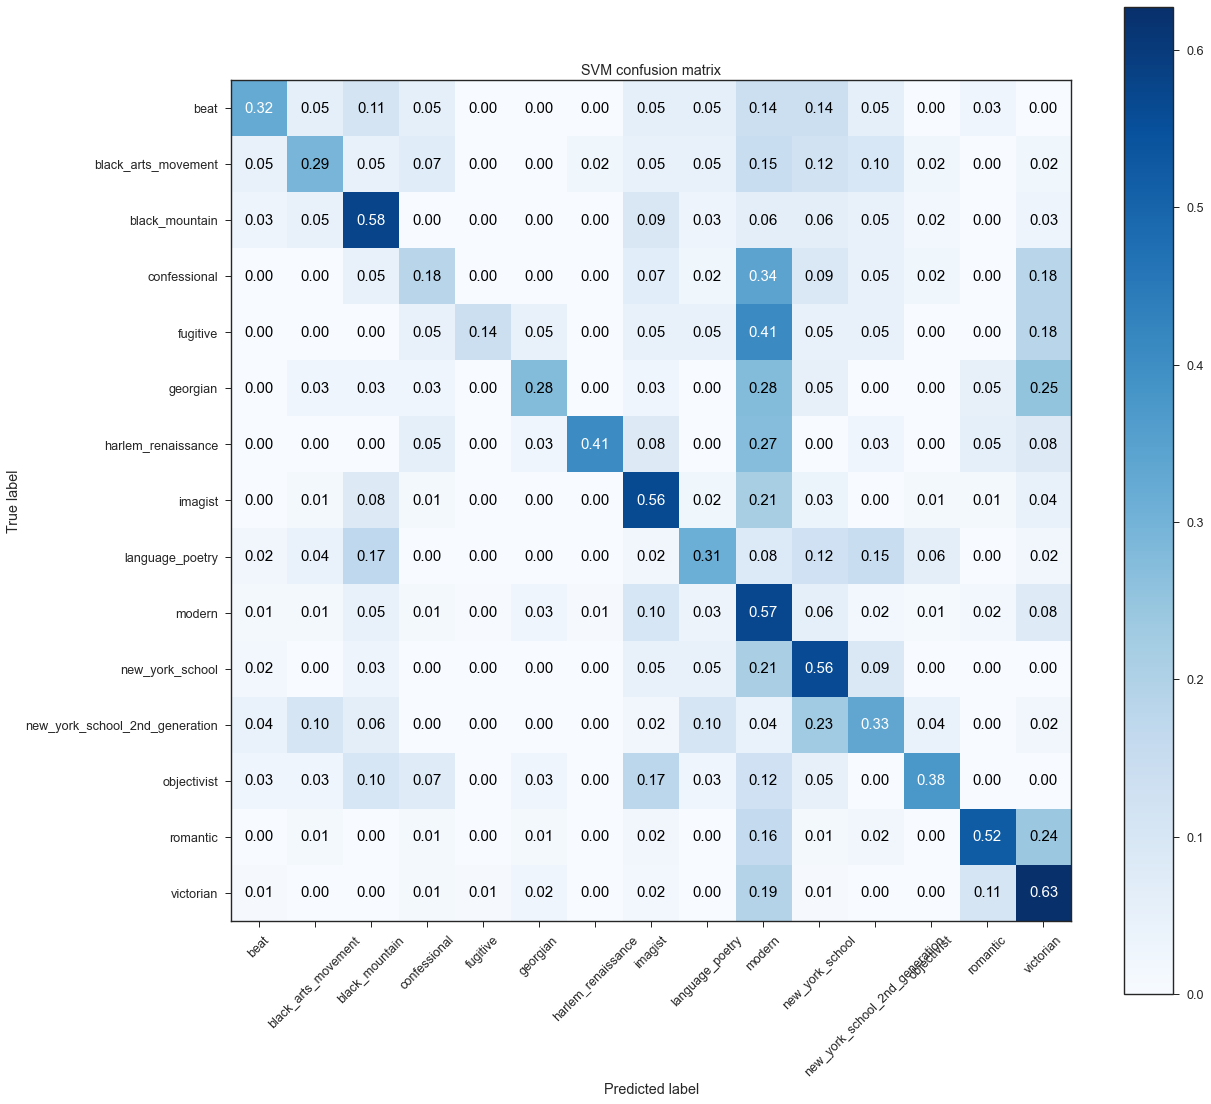

In [58]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

- **Still overfit but nearly a 10% increase in the test predictions!**

### Feature importances

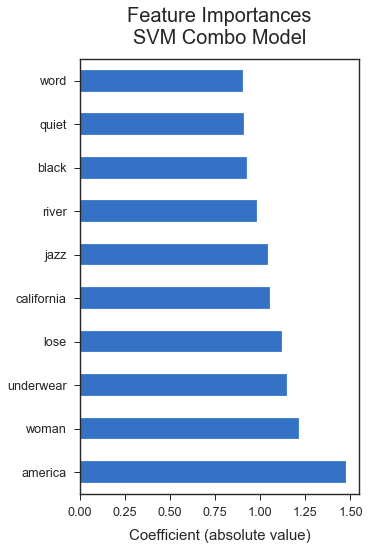

In [59]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [47]:
%%time

# instantiate the model
svm_combo2 = SVC(C=2, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 14min 16s, sys: 2.21 s, total: 14min 18s
Wall time: 14min 19s


SVC(C=2, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9746324589218796
F1 score: 0.9745159835142977

-----TEST-----
Accuracy: 0.5229040622299049
F1 score: 0.5068756674846989

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.55      0.32      0.41        37
           black_arts_movement       0.50      0.27      0.35        41
                black_mountain       0.38      0.44      0.41        64
                  confessional       0.39      0.16      0.23        44
                      fugitive       0.75      0.14      0.23        22
                      georgian       0.63      0.30      0.41        40
            harlem_renaissance       0.85      0.30      0.44        37
                       imagist       0.53      0.54      0.54        89
               language_poetry       0.37      0.27      0.31        48
                        mode

### Confusion matrix visualization

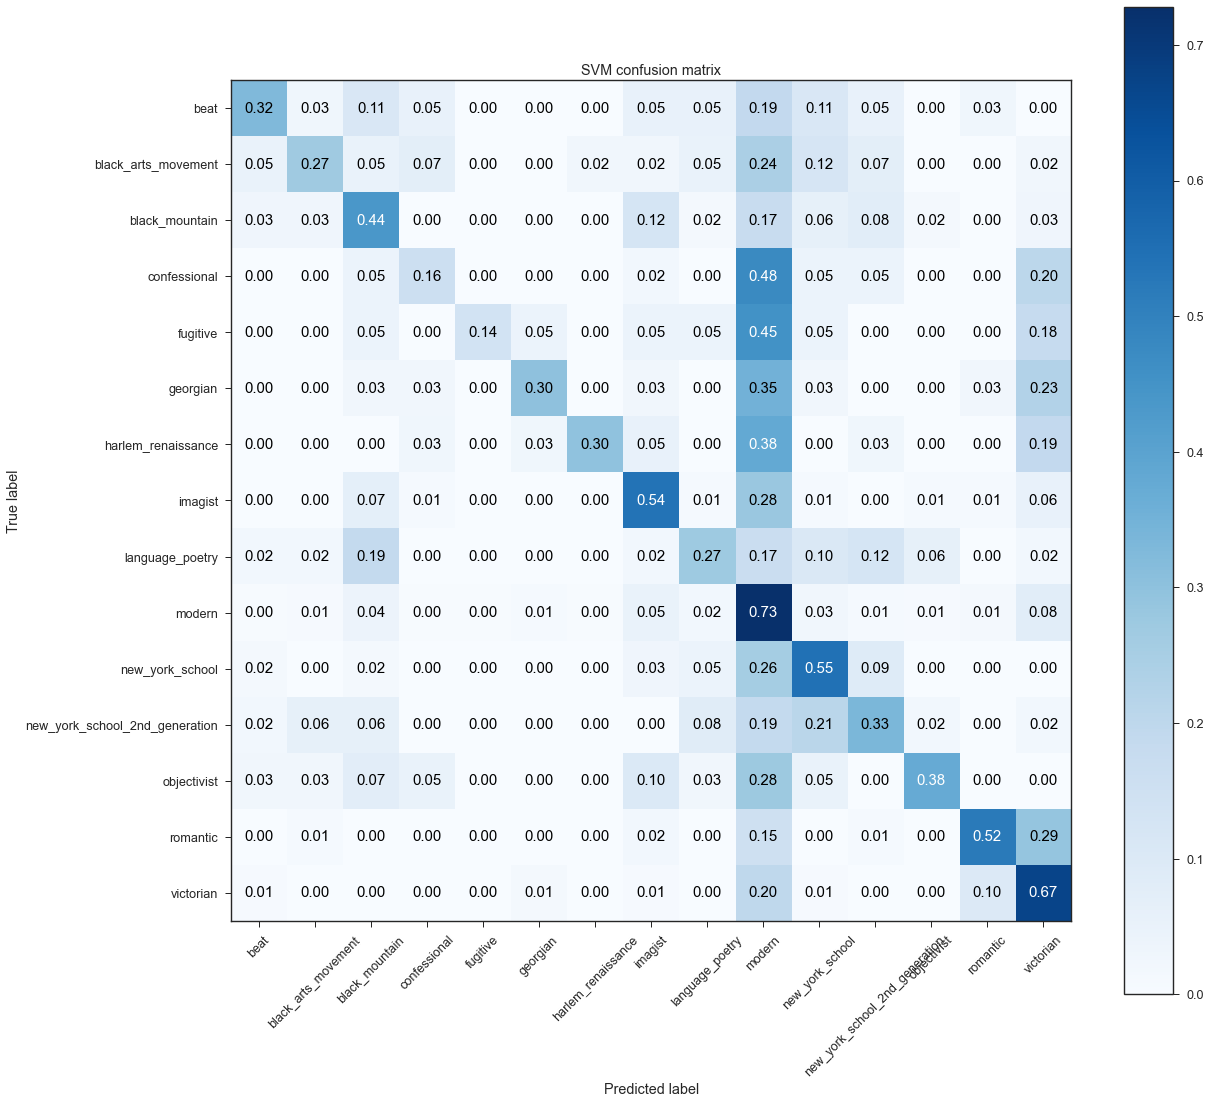

In [52]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

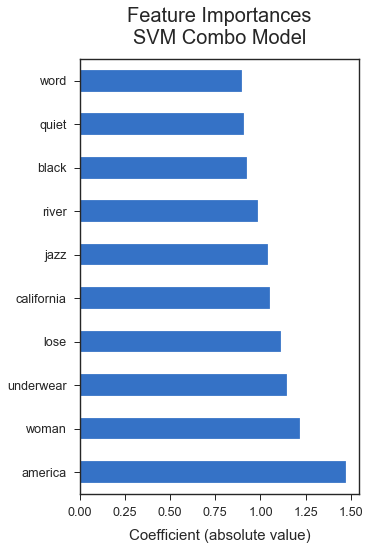

In [50]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');

- **The number of words per line dropped down, but still in the top ten.**

# Modeling conclusions
- **Form/structure is important for prediction (especially Random Forest models).**
    - **Further exploration desired:**
        - **Other types of rhyme**
        - **Use of line breaks, tabs, and spacing**
        - **Topic modeling**
- **SVM relies mostly on vocabulary.**
    - **Further exploration desired:**
        - **Word embeddings (self-trained and pre-trained)**
        - **POS tagging**
- **SVM is the best model!**

- **Mostly surprising words, other than maybe 'get', which was a top 5 frequent word.**
- **Nice to see an engineered feature in the top spot.**

### Changing C value and class weight.

In [60]:
%%time

# instantiate the model
svm_combo2 = SVC(C=3, kernel='linear', class_weight='balanced')

# fit to the training set
svm_combo2.fit(X_train_combo, y_train)

CPU times: user 15min 24s, sys: 2.04 s, total: 15min 26s
Wall time: 15min 26s


SVC(C=3, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [61]:
%%time

# predict class for the train and test sets
y_train_preds_svm_combo2 = svm_combo2.predict(X_train_combo)
y_test_preds_svm_combo2 = svm_combo2.predict(X_test_combo)

# print out accuracy and f1 scores for train set
svm_combo_acc_train2 = accuracy_score(y_train, y_train_preds_svm_combo2)
svm_combo_f1_train2 = f1_score(y_train, y_train_preds_svm_combo2, average='weighted')

print('-----TRAIN-----')
print(f'Accuracy: {svm_combo_acc_train2}')
print(f'F1 score: {svm_combo_f1_train2}')

# print out accuracy and f1 scores for test set
svm_combo_acc_test2 = accuracy_score(y_test, y_test_preds_svm_combo2)
svm_combo_f1_test2 = f1_score(y_test, y_test_preds_svm_combo2, average='weighted')

print('\n-----TEST-----')
print(f'Accuracy: {svm_combo_acc_test2}')
print(f'F1 score: {svm_combo_f1_test2}')

print('\n' + '-' * 100 + '\n')

# print out report for test predictions
print(classification_report(y_test, y_test_preds_svm_combo2, target_names=list(y.unique())))

print('\n' + '-' * 100 + '\n')

# print out confusion matrix
print("CONFUSION MATRIX:\n")
print(confusion_matrix(y_test, y_test_preds_svm_combo2))

-----TRAIN-----
Accuracy: 0.9870279619486884
F1 score: 0.9870039400530103

-----TEST-----
Accuracy: 0.5280898876404494
F1 score: 0.5069791602171194

----------------------------------------------------------------------------------------------------

                                precision    recall  f1-score   support

                          beat       0.60      0.32      0.42        37
           black_arts_movement       0.45      0.24      0.32        41
                black_mountain       0.47      0.42      0.44        64
                  confessional       0.44      0.16      0.23        44
                      fugitive       0.75      0.14      0.23        22
                      georgian       0.71      0.25      0.37        40
            harlem_renaissance       0.91      0.27      0.42        37
                       imagist       0.54      0.51      0.52        89
               language_poetry       0.35      0.25      0.29        48
                        mode

### Confusion matrix visualization

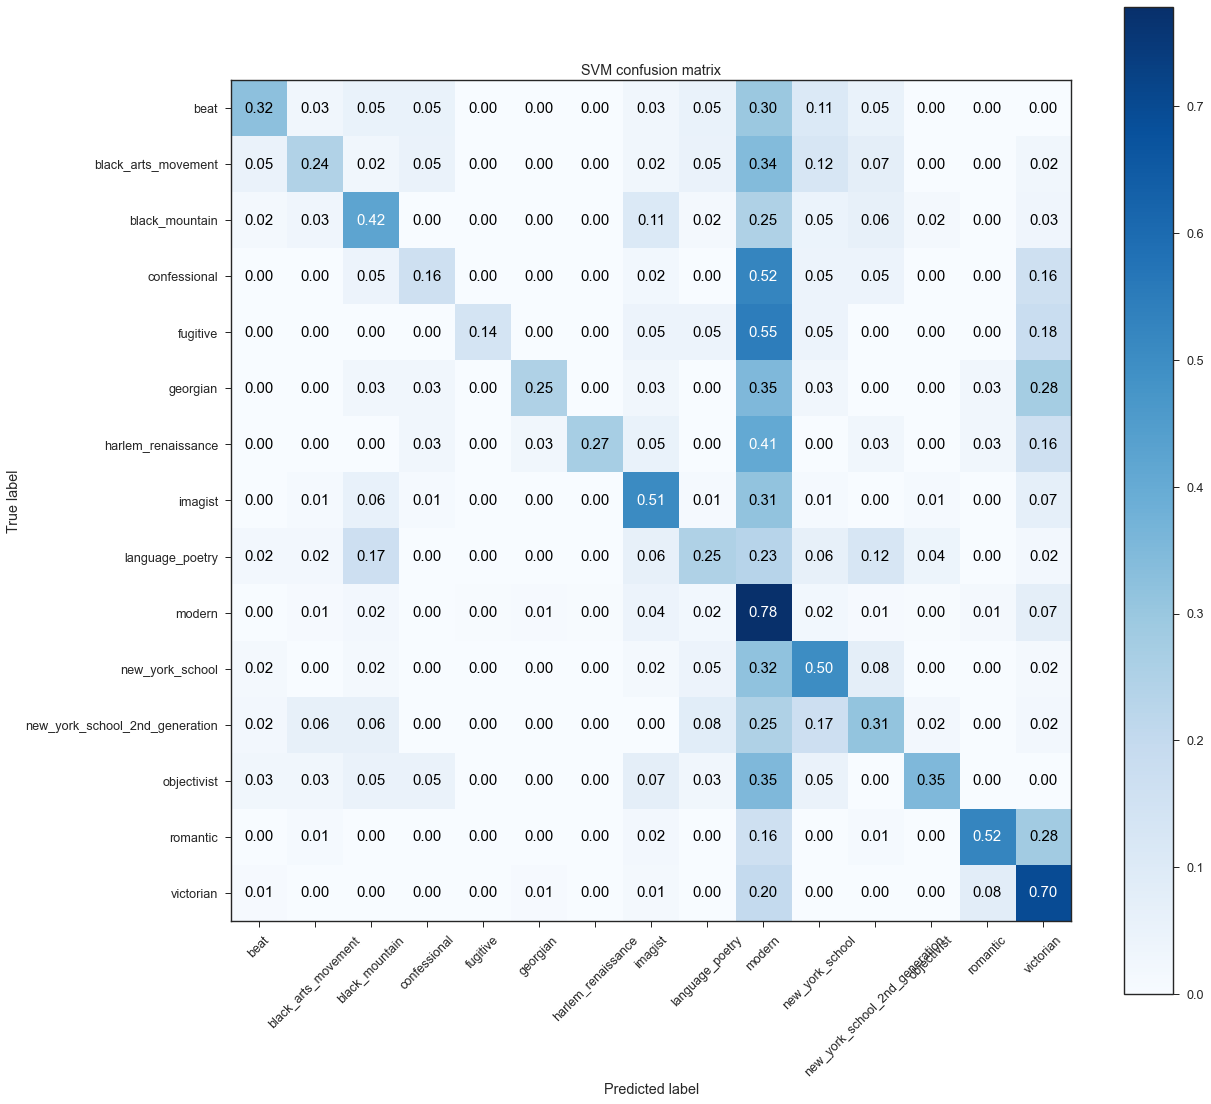

In [62]:
cm = confusion_matrix(y_test, y_test_preds_svm_combo2)
classes = y.unique()

plt.figure(figsize=(18,16))
plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='SVM confusion matrix',
                          cmap=plt.cm.Blues);

### Feature importances

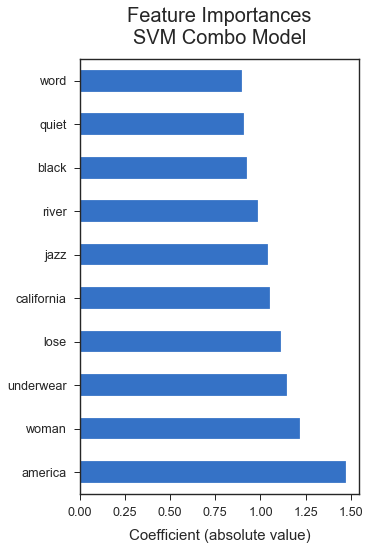

In [63]:
# prettify graph
plt.figure(figsize=(5,8))
plt.title('Feature Importances\nSVM Combo Model', fontsize=20, pad=15)
plt.xlabel('Coefficient (absolute value)', fontsize=15, labelpad=10)

# plot top ten features
pd.Series(abs(svm_combo2.coef_[0]), index=X_train_combo.columns).nlargest(10).plot(kind='barh');